#**Cataract vs. Normal Fundus Identification**

##**Problem Statement:**

Create and identify a deep learning model to identify whether an inputted color fundnus photograph depicts a cataract eye or normal eye.

##**Objectives:**

* Understand the correlations between individuals diagnosed with having cataracts and their age, gender, and other eye diseases
* Train at least three models for image classification (cataract vs. normal fundus classification using a CNN-based model, a VGG model, and InceptionV3 model)
* Evaluate the performances of each model to identify the best-performing model out of those trained
* Train at least one model to have a minimum accuracy of 70%
* Create a platform utilizing the best-performing model that allows users to submit fundus photographs and recieve a classification of cataract vs. normal

##**Fetching Data:**

Mounting Google Drive and Fetching Data:

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle_credentials/kaggle_cred.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:11<00:00, 130MB/s]
100% 1.62G/1.62G [00:11<00:00, 150MB/s]


In [ ]:
! unzip ocular-disease-recognition-odir5k.zip

In [ ]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dropout, Dense, Embedding
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

##**Metadata:**



Columns in the dataframe:
* Age of patient
* Sex of patient
* File name - Color fundus photograph of left eye
* File name - Color fundus photograph of right eye
* Keywords of left eye diagnosis
* keywords of right eye diagnosis

The next 8 columns are one-hot encoded diagnoses of patients:
* Normal
* Diabetes
* Glaucoma
* Cataract
* AMD - 
( Age related Macular Degeneration) 
* Hypertension
* Pathological Myopia
* Other diseases/abnormalities

This is followed by:
* filepath (of each image)
* labels (assigned by the doctors to either the left or right eye, specified in "filename")
* target (one-hot encoded labels assigned to each patient)
* filename (that references the labelled eye)

##**Exploratory Analysis:**

In [ ]:
df = pd.read_csv("/content/full_df.csv")

In [ ]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df.shape

(6392, 19)

Removing unecessary identifiers, renaming columns for readability::

In [ ]:
df = df.drop(['ID'], axis=1)

In [ ]:
df.columns = ["age", "sex", "left_fundus", "right_fundus", "left_diagnosis", "right_diagnosis", "normal", "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other", "filepath", "labels", "target", "filename"]

No null values

In [ ]:
df.isnull().sum()

age                0
sex                0
left_fundus        0
right_fundus       0
left_diagnosis     0
right_diagnosis    0
normal             0
diabetes           0
glaucoma           0
cataract           0
amd                0
hypertension       0
myopia             0
other              0
filepath           0
labels             0
target             0
filename           0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              6392 non-null   int64 
 1   sex              6392 non-null   object
 2   left_fundus      6392 non-null   object
 3   right_fundus     6392 non-null   object
 4   left_diagnosis   6392 non-null   object
 5   right_diagnosis  6392 non-null   object
 6   normal           6392 non-null   int64 
 7   diabetes         6392 non-null   int64 
 8   glaucoma         6392 non-null   int64 
 9   cataract         6392 non-null   int64 
 10  amd              6392 non-null   int64 
 11  hypertension     6392 non-null   int64 
 12  myopia           6392 non-null   int64 
 13  other            6392 non-null   int64 
 14  filepath         6392 non-null   object
 15  labels           6392 non-null   object
 16  target           6392 non-null   object
 17  filename         6392 non-null   

####**There is a slight issue here regarding the given data representation:**
* Each row of the dataframe represents one patient
* So each row also consists of images for two eyes, not one
* The "target" and "labels" features represent the doctors' diagnosis for each patient, not for each eye
* Since our model will identify diseases in a single photo at a time, these two features are not valuable beyond the exploratory analysis stage. They will be dropped later on.

In [ ]:
import os

# folder path
dir_path = r'/content/preprocessed_images'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 6392


In [ ]:
df.head()

,age,sex,left_fundus,right_fundus,left_diagnosis,right_diagnosis,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
cpy = df[df["left_fundus"] == "0_left.jpg"]

In [ ]:
cpy

,age,sex,left_fundus,right_fundus,left_diagnosis,right_diagnosis,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg


In [ ]:
cpy = df.drop_duplicates()
cpy.shape

(6392, 18)

It was found during the data preprocessing stage that not all cataract patients in this dataset can be identified solely using the "labels" feature having the value "['C']" or the "cataract" feature. To find all the cataract patients' records, we must search the left and right diagnoses for the word "cataract".

In [ ]:
df_cat_lhs = df[df['left_diagnosis'].str.contains('cataract')]
df_cat_rhs = df[df['right_diagnosis'].str.contains('cataract')]
df_cataract = pd.concat([df_cat_lhs, df_cat_rhs]).drop_duplicates()
df_cataract.head()

,age,sex,left_fundus,right_fundus,left_diagnosis,right_diagnosis,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
65,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",119_right.jpg
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",254_right.jpg


In [ ]:
df_cataract.shape

(402, 18)

In [ ]:
print(100* len(df_cataract)/len(df))

6.289111389236545


Around 6% of all patients in our data (around 402 individuals) were diagnosed with having cataract in either the left eye or the right eye.

In [ ]:
df["labels"].value_counts()

['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: labels, dtype: int64

Text(0.5, 1.0, 'Histogram of Eye Diseases Among Cataract Patients:')

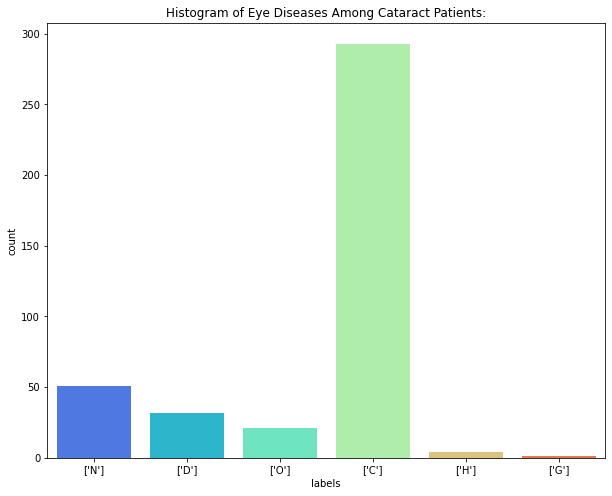

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x='labels',data=df_cataract, palette='rainbow')
plt.title("Histogram of Eye Diseases Among Cataract Patients:")

* Patients who were diagnosed with having cataract in either eye have been primarily diagnosed with cataract itself
* Other diagnoses include having normal funduses, diabetic retinopathy, and other disease
* No patients diagnosed with cataract have been found to have age-related macular degeneration or myopia

Text(0.5, 1.0, 'Sex of Cataract Patients:')

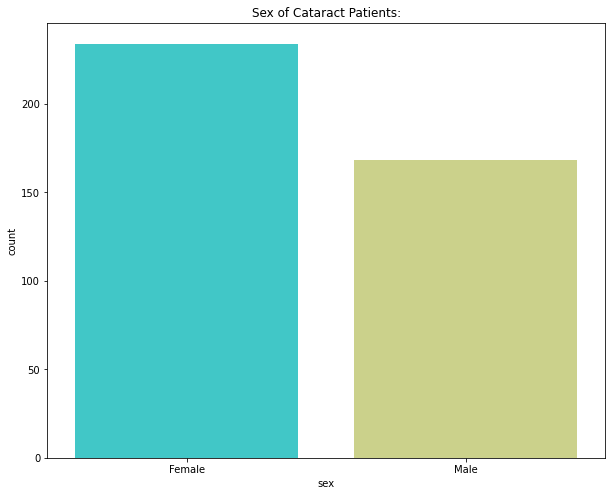

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x='sex',data=df_cataract, palette='rainbow')
plt.title("Sex of Cataract Patients:")

A little over half of the cataract patients in this dataset are female. This is consistent with a study conducted that states that women make up 63% of the cataract patient population (https://www.researchgate.net/publication/11300294_Gender_and_use_of_cataract_surgical_services_in_developing_countries#:~:text=Despite%20their%20lower%20coverage%20rate,(range%204%2D21%25).)

Text(0.5, 1.0, 'Distribution of Age and Sex Among Cataract Patients')

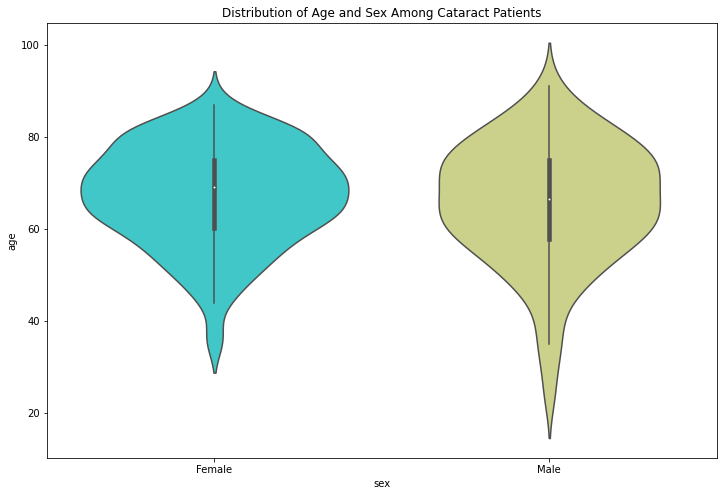

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='sex',y="age", data=df_cataract, palette='rainbow')
plt.title("Distribution of Age and Sex Among Cataract Patients")

* Patients between the ages of 50-80 make up the majority of the cataract patient population
* Women in the age range of 60s-70s are the most likely to be affected by cataracts
* When examining individuals in the age group of 30 and below, males are much more likely to be diagnosed with having cataracts than females.

#####**NGrams of Diagnoses:**

According to an article in the NCBI:

"Cataract is one of the major causes of visual impairment in diabetic patients. Patients with DM are reported to be up to five times more likely to develop cataract, in particular at an early age."

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6422859/#:~:text=Cataract%20is%20one%20of%20the,diabetic%20cataracts%20has%20also%20risen.

* Is this supported by our data?
* What other keywords are used in the diagnoses of patients with cataracts? What insights can we draw form this?

In [ ]:
contractions = {
"a'ight":"alright",
"ain't":"are not",
"amn't":"am not",
"aren't":"are not",
"can't":"cannot",
"'cause": "because",
"could've":"could have",
"couldn't":"could not",
"couldn't've":"could not have",
"daren't":"dare not",
"daresn't":"dare not",
"dasn't":"dare not",
"didn't":"did not",
"doesn't":"does not",
"don't":"do not",
"everybody's":"everybody is",
"everyone's":"everyone is",
"giv'n":"given",
"gonna":"going to",
"gon't":"go not", 
"gotta":"got to",
"hadn't":"had not",
"had've":"had have",
"hasn't":"has not",
"haven't":"have not",
"he'd":"he had", 
"he'll":"he will",
"he's":"he is",
"here's":"here is",
"how'd":"how did",
"how'll":"how will",
"how're":"how are",
"how's":"how is",
"I'd":"I had",
"I'd've":"I would have",
"I'd'nt":"I would not",
"I'd'nt've":"I would not have",
"I'll":"I will",
"I'm":"I am",
"I've":"I have",
"isn't":"is not",
"it'd":"it would",
"it'll":"it will",
"it's":"it is",
"let's":"let us",
"ma'am":"madam",
"mayn't":"may not",
"may've":"may have",
"mightn't":"might not",
"might've":"might have",
"mustn't":"must not",
"mustn't've":"must not have",
"must've":"must have",
"needn't":"need not",
"needn't've":"need not have",
"o'clock":"of the clock",
"oughtn't":"ought not",
"oughtn't've":"ought not have",
"shan't":"shall not",
"she'd":"she would",
"she'll":"she will",
"she's":"she is",
"should've":"should have",
"shouldn't":"should not",
"shouldn't've":"should not have",
"somebody's":"somebody is",
"someone's":"someone is",
"something's":"something is",
"so're":"so are",
"so’s":"so is",
"so’ve":"so have",
"that'll":"that will",
"that're":"that are",
"that's":"that is",
"that'd":"that would",
"there'd":"there would",
"there'll":"there will",
"there're":"there are",
"there's":"there is",
"these're":"these are",
"these've":"these have",
"they'd":"they would",
"they'll":"they will",
"they're":"they are",
"they've":"they have",
"this's":"this is",
"those're":"those are",
"those've":"those have",
"to've":"to have",
"wasn't":"was not",
"we'd":"we would",
"we'd've":"we would have",
"we'll":"we will",
"we're":"we are",
"we've":"we have",
"weren't":"were not",
"what'd":"what did",
"what'll":"what will",
"what're":"what are",
"what's":"what is",
"what've":"what have",
"when's":"when is",
"where'd":"where did",
"where'll":"where will",
"where're":"where are",
"where's":"where is",
"where've":"where have",
"which'd":"which would",
"which'll":"which will",
"which're":"which are",
"which's":"which is",
"which've":"which have",
"who'd":"who would",
"who'd've":"who would have",
"who'll":"who will",
"who're":"who are",
"who's":"who is",
"who've":"who have",
"why'd":"why did",
"why're":"why are",
"why's":"why is",
"won't":"will not",
"would've":"would have",
"wouldn't":"would not",
"wouldn't've":"would not have",
"y'at":"you at",
"yes’m":"yes madam",
"you'd":"you would",
"you'll":"you will",
"you're":"you are",
"you've":"you have",
"br": " "
}

In [ ]:
def cont_to_exp(x):
    if type(x) is str:
        x = x.replace('\\','')
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [ ]:
def upper_to_lower(x):
    if type(x) is str:
        return x.lower()
    else:
        return x

In [ ]:
import string
def remove_punctuations(text):
    if type(text) is str:
        for p in string.punctuation:
            text = text.replace(p, '')
        return text
    else:
        return text 

In [ ]:
def remove_special_chars(text):
    special_chars = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    if type(text) is str:
        for p in special_chars:
            text = text.replace(p, '')
        return text
    else:
        return text

In [ ]:
import nltk.corpus
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import textblob

In [ ]:
df_cpy = df
df_cpy["diagnosis"] = df_cpy["left_diagnosis"] + " " + df_cpy["right_diagnosis"]
df_cpy = df_cpy.drop(['left_diagnosis', 'right_diagnosis'], axis=1)
df_cpy.head()

,age,sex,left_fundus,right_fundus,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename,diagnosis
0,69,Female,0_left.jpg,0_right.jpg,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,cataract normal fundus
1,57,Male,1_left.jpg,1_right.jpg,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,normal fundus normal fundus
2,42,Male,2_left.jpg,2_right.jpg,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,laser spot，moderate non proliferative retinopa...
3,53,Male,4_left.jpg,4_right.jpg,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,macular epiretinal membrane mild nonproliferat...
4,50,Female,5_left.jpg,5_right.jpg,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,moderate non proliferative retinopathy moderat...


In [ ]:
df_cpy["diagnosis"] = df_cpy["diagnosis"].apply(lambda x:cont_to_exp(x))
df_cpy["diagnosis"] = df_cpy["diagnosis"].apply(lambda x:upper_to_lower(x))
df_cpy["diagnosis"] = df_cpy["diagnosis"].apply(lambda x:remove_punctuations(x))
df_cpy["diagnosis"] = df_cpy["diagnosis"].apply(lambda x:remove_special_chars(x))
df_cpy["diagnosis"] = df_cpy["diagnosis"].str.replace(r's*https?://S+(s+|$),', ' ').str.strip()
df_cpy["diagnosis"] = df_cpy["diagnosis"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [ ]:
df_cpy.head()

,age,sex,left_fundus,right_fundus,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename,diagnosis
0,69,Female,0_left.jpg,0_right.jpg,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,cataract normal fundus
1,57,Male,1_left.jpg,1_right.jpg,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,normal fundus normal fundus
2,42,Male,2_left.jpg,2_right.jpg,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,laser spot，moderate non proliferative retinopa...
3,53,Male,4_left.jpg,4_right.jpg,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,macular epiretinal mem ane mild nonproliferati...
4,50,Female,5_left.jpg,5_right.jpg,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,moderate non proliferative retinopathy moderat...


In [ ]:
df_cpy_cataract = df_cpy[df_cpy['diagnosis'].str.contains('cataract')]
df_cpy_cataract.head()

,age,sex,left_fundus,right_fundus,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename,diagnosis
0,69,Female,0_left.jpg,0_right.jpg,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,cataract normal fundus
20,75,Female,24_left.jpg,24_right.jpg,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg,normal fundus cataract
65,66,Male,81_left.jpg,81_right.jpg,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg,moderate non proliferative retinopathy，catarac...
86,55,Female,103_left.jpg,103_right.jpg,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg,cataract normal fundus
93,57,Female,112_left.jpg,112_right.jpg,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg,normal fundus cataract


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_n_words(x, n=None):
    vec = CountVectorizer(stop_words='english').fit(x)
    bag_of_words = vec.transform(x)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

According to the unigram below, around 1/6th of cataract patients have cataract in only one eye:
* There are nearly 600 instances of the word "cataract"
* And nearly 100 instances of the word "normal"
* Since these keywords are used exclusively in both the "left_diagnosis" and "right_diagnosis" columns, this means that out of around 600 cataract patients, nearly 100 have cataract in only 1 eye while the other was diagnosed as "normal"
* Nearly 1/6th of all our cataract patients have retinopathy as well. What about the other way round?

In [ ]:
common_words = get_top_n_words(df_cpy_cataract['diagnosis'], 25)
df_unigram = pd.DataFrame(common_words, columns = ['Unigram Text', 'Count'])
df_unigram

,Unigram Text,Count
0,cataract,596
1,normal,107
2,fundus,107
3,retinopathy,96
4,proliferative,64
5,moderate,59
6,non,59
7,lens,42
8,dust,42
9,mild,24


In [ ]:
df_dr = df[df["labels"] == "['D']"]
len(df_dr)

1608

The unigram below shows little correlation between diagnoses having both keywords "retinopathy" and "cataract". We need more domain knowledge to confirm the link between these two eye diseases.

In [ ]:
common_words = get_top_n_words(df_dr['diagnosis'], 25)
df_unigram = pd.DataFrame(common_words, columns = ['Unigram Text', 'Count'])
df_unigram

,Unigram Text,Count
0,retinopathy,2945
1,proliferative,1686
2,moderate,1633
3,non,1633
4,nonproliferative,1101
5,mild,794
6,severe,321
7,fundus,233
8,normal,231
9,epiretinal,132


##**Data Preprocessing:**

Removing the "target" feature as it is repetitive:

In [ ]:
df = df.drop(['target'], axis=1)

In [ ]:
df.head(20)

,age,sex,left_fundus,right_fundus,left_diagnosis,right_diagnosis,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,filename,diagnosis
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],0_right.jpg,cataract normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],1_right.jpg,normal fundus normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],2_right.jpg,laser spot，moderate non proliferative retinopa...
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],4_right.jpg,macular epiretinal membrane mild nonproliferat...
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],5_right.jpg,moderate non proliferative retinopathy moderat...
5,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],6_right.jpg,macular epiretinal membrane moderate non proli...
6,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],7_right.jpg,drusen mild nonproliferative retinopathy
7,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],8_right.jpg,normal fundus normal fundus
8,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],9_right.jpg,normal fundus vitreous degeneration
9,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],10_right.jpg,epiretinal membrane normal fundus


As seen below, if we use just the images classified as "['C']" (representing "cataract") under the "target" variable, we will have only 293 images. However, if we use  keywords in the diagnoses to find our cataract images instead, we end up with nearly twice the number of cataract pictures (290 + 304 = 594).

In [ ]:
from PIL import Image
  
# get image
filepath = "/content/preprocessed_images/0_left.jpg"
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height
  
# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)

The height of the image is:  512
The width of the image is:  512


In [ ]:
cat_count = df[df['labels']=="['C']"]
len(cat_count)

293

In [ ]:
right_cat_count = df[df['right_diagnosis'].str.contains('cataract')]
len(right_cat_count)

290

In [ ]:
left_cat_count = df[df['left_diagnosis'].str.contains('cataract')]
len(left_cat_count)

304

As a result, the keywords will be used to identify our "cateract" vs. "normal" classes rather than the 'labels' variable

Use "match" rather than "contains" here as the keyword "abnormal" can corrupt our data otherwise

In [ ]:
right_norm_count = df[df['right_diagnosis'].str.match('normal')]
len(right_norm_count)

2735

In [ ]:
left_norm_count = df[df['left_diagnosis'].str.match('normal')]
len(left_norm_count)

2855

Creating a separate dataframe just of cataract and normal images:

In [ ]:
right_df = right_cat_count[["right_fundus", "right_diagnosis"]]
right_df.head()

,right_fundus,right_diagnosis
20,24_right.jpg,cataract
65,81_right.jpg,moderate non proliferative retinopathy，cataract
93,112_right.jpg,cataract
160,188_right.jpg,cataract
186,218_right.jpg,cataract


In [ ]:
right_df.columns = ["fundus", "diagnosis"]
right_df.head()

,fundus,diagnosis
20,24_right.jpg,cataract
65,81_right.jpg,moderate non proliferative retinopathy，cataract
93,112_right.jpg,cataract
160,188_right.jpg,cataract
186,218_right.jpg,cataract


In [ ]:
left_df = left_cat_count[["left_fundus", "left_diagnosis"]]
left_df.columns = ["fundus", "diagnosis"]
cat_df = pd.concat([right_df, left_df])

In [ ]:
cat_df["diagnosis"] = "cataract"
cat_df=cat_df.reset_index(drop=True)
cat_df.head()

,fundus,diagnosis
0,24_right.jpg,cataract
1,81_right.jpg,cataract
2,112_right.jpg,cataract
3,188_right.jpg,cataract
4,218_right.jpg,cataract


In [ ]:
right_df = right_norm_count[["right_fundus", "right_diagnosis"]]
right_df.columns = ["fundus", "diagnosis"]
right_df.head()

,fundus,diagnosis
0,0_right.jpg,normal fundus
1,1_right.jpg,normal fundus
7,8_right.jpg,normal fundus
9,10_right.jpg,normal fundus
24,29_right.jpg,normal fundus


In [ ]:
left_df = left_norm_count[["left_fundus", "left_diagnosis"]]
left_df.columns = ["fundus", "diagnosis"]
norm_df = pd.concat([right_df, left_df])
norm_df["diagnosis"] = "normal"

In [ ]:
norm_df = norm_df.sample(n = len(cat_df))

In [ ]:
norm_df=norm_df.reset_index(drop=True)
norm_df.head()

,fundus,diagnosis
0,2933_left.jpg,normal
1,3120_left.jpg,normal
2,894_left.jpg,normal
3,190_left.jpg,normal
4,1092_left.jpg,normal


Displaying what our cataract vs. normal funduses look like:

In [ ]:
import cv2

In [ ]:
path = "/content/preprocessed_images"

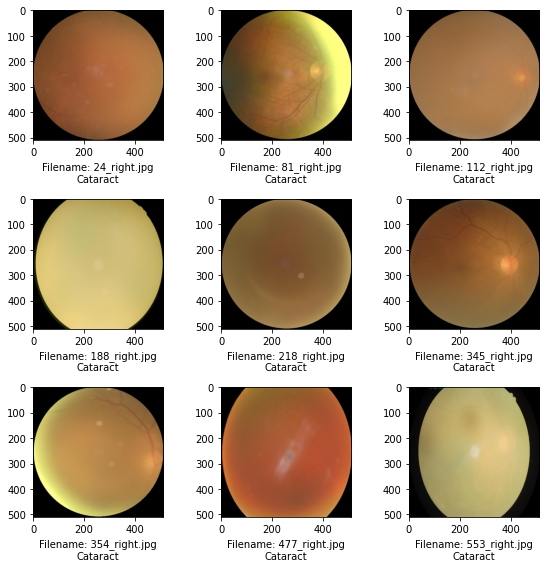

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = cat_df.loc[i, "fundus"]
    image = cv2.imread(os.path.join(path, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(cat_df.loc[i, "fundus"]))

plt.tight_layout() 

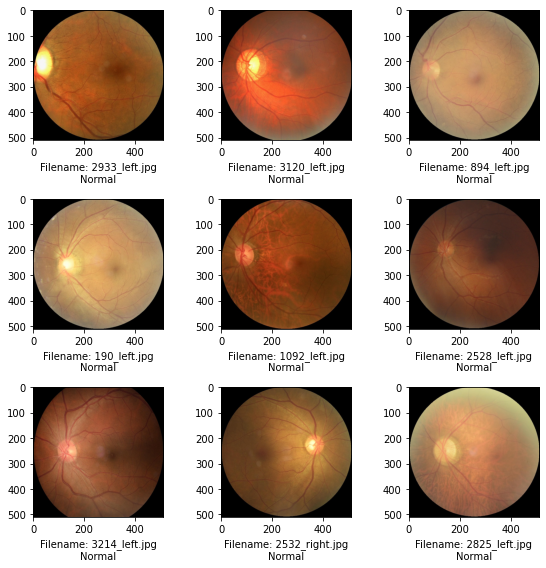

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = norm_df.loc[i, "fundus"]
    image = cv2.imread(os.path.join(path, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(norm_df.loc[i, "fundus"]))

plt.tight_layout() 

Merging both our cataract and normal dataframes into one:

In [ ]:
final_df = pd.concat([cat_df, norm_df])
final_df=final_df.reset_index(drop=True)

In [ ]:
final_df["diagnosis"].value_counts()

cataract    594
normal      594
Name: diagnosis, dtype: int64

In [ ]:
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df

,fundus,diagnosis
0,2239_left.jpg,cataract
1,385_left.jpg,normal
2,3178_left.jpg,normal
3,1415_right.jpg,cataract
4,2117_left.jpg,cataract
...,...,...
1183,2141_right.jpg,cataract
1184,2194_left.jpg,cataract
1185,2126_left.jpg,cataract
1186,629_left.jpg,cataract


Preprocessing Pipeline:

In [ ]:
train_df = final_df.sample(frac=0.8,random_state=42)
train_df.reset_index(drop=True)

test_df = final_df.drop(train_df.index)
test_df.reset_index(drop=True)

print("Size of all dataframe:",  len(final_df))
print("Size of training dataframe:",  len(train_df))
print("Size of testing dataframe:",  len(test_df))

Size of all dataframe: 1188
Size of training dataframe: 950
Size of testing dataframe: 238


Using ImageDataGenerator to augment our images (to train our models with transformed images for better generalizability):

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            rotation_range=90,
            width_shift_range=0.2,
            validation_split=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]  
            )

test_datagen=ImageDataGenerator(rescale=1./255.)

I will be comparing the results of 3 models in the future: 
A CNN-based model, VGG Model, and an InceptionV3 model.



Creating the train, test, and validation generators for our models (differing in input size):

For the CNN-based model:

In [ ]:
cnn_train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

cnn_valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    subset="validation",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(256,256))

cnn_test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(256,256))

Found 756 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Found 237 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 5 invalid image filename(s) in x_col="fundus". These filename(s) will be ignored.
  n_invalid, x_col))
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 1 invalid image filename(s) in x_col="fundus". These filename(s) will be ignored.
  n_invalid, x_col))


For VGGNet, which takes only input of size 224x224:

In [ ]:
vgg_train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

vgg_valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    subset="validation",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(224,224))

vgg_test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(224,224))

Found 756 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Found 237 validated image filenames belonging to 2 classes.


For the InceptionV3 model:

In [ ]:
inc_train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299))

inc_valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    subset="validation",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(299,299))

inc_test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col="fundus",
    y_col="diagnosis",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(299,299))

Found 756 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Found 237 validated image filenames belonging to 2 classes.


##**Models:**

#####**CNN:**

Verifying that the input images and labels are as expected before passing into the model:

In [ ]:
cnn_images, cnn_labels = cnn_train_generator.next()

cnn_images.shape

(32, 256, 256, 3)

In [ ]:
cnn_labels[0]

array([0., 1.], dtype=float32)

Building the model:

In [ ]:
cnn_model = tf.keras.Sequential()

In [ ]:
cnn_model.add(tf.keras.Input((256,256,3)))
cnn_model.add(tf.keras.layers.Conv2D(32, strides = (1,1), kernel_size= (3,3), activation = "relu" , padding = "valid"))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides =  (2, 2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(100, activation = "relu"))
cnn_model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

Summary of the model:

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 100)               51612900  
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 51,613,998
Trainable params: 51,613,998
Non-trainable params: 0
____________________________________________

Compiling the model:

In [ ]:
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Fitting the model:

In [ ]:
cnn_history = cnn_model.fit(
cnn_train_generator,
      epochs=10,
      validation_data=cnn_valid_generator,
      verbose=1)

Epoch 1/10
24/24 [==============================] - 63s 3s/step - loss: 0.9082 - acc: 0.5503 - val_loss: 0.7076 - val_acc: 0.5608
Epoch 2/10
24/24 [==============================] - 58s 2s/step - loss: 0.6974 - acc: 0.6032 - val_loss: 0.7361 - val_acc: 0.5503
Epoch 3/10
24/24 [==============================] - 60s 2s/step - loss: 0.6814 - acc: 0.5847 - val_loss: 0.7424 - val_acc: 0.5661
Epoch 4/10
24/24 [==============================] - 58s 2s/step - loss: 0.7293 - acc: 0.5939 - val_loss: 0.7197 - val_acc: 0.5873
Epoch 5/10
24/24 [==============================] - 58s 2s/step - loss: 0.6556 - acc: 0.6005 - val_loss: 0.6291 - val_acc: 0.6508
Epoch 6/10
24/24 [==============================] - 60s 2s/step - loss: 0.6249 - acc: 0.6389 - val_loss: 0.6235 - val_acc: 0.6720
Epoch 7/10
24/24 [==============================] - 60s 2s/step - loss: 0.6329 - acc: 0.6455 - val_loss: 0.6036 - val_acc: 0.6508
Epoch 8/10
24/24 [==============================] - 58s 2s/step - loss: 0.6496 - acc: 0.61

In [ ]:
tf.keras.models.save_model(cnn_model, 'cnn1.hdf5')

#####**VGG-based Models:**

Verifying that the input images and labels are as expected before passing into the model:

In [ ]:
vgg_images, vgg_labels = vgg_train_generator.next()

vgg_images.shape

(32, 224, 224, 3)

In [ ]:
vgg_labels[0]

array([1., 0.], dtype=float32)

Building the model (freezing layers for transfer learning):

In [ ]:
from keras.applications.vgg16 import VGG16

vgg_frozen = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
vgg_frozen.trainable = False 
vgg_frozen.summary()

Fine-tuning the transfer learning model:

In [ ]:
vgg_model = tf.keras.Sequential([
    vgg_frozen,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Summary and compilation of the model:

In [ ]:
vgg_model.summary()

vgg_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


Fitting the model to the data:

In [ ]:
vgg_history = vgg_model.fit(
vgg_train_generator,
      epochs=10,
      validation_data=vgg_valid_generator,
      verbose=1)

Epoch 1/10
24/24 [==============================] - 507s 21s/step - loss: 0.6137 - acc: 0.6825 - val_loss: 0.5763 - val_acc: 0.7619
Epoch 2/10
24/24 [==============================] - 496s 21s/step - loss: 0.5431 - acc: 0.7632 - val_loss: 0.5256 - val_acc: 0.7989
Epoch 3/10
24/24 [==============================] - 497s 21s/step - loss: 0.5054 - acc: 0.7857 - val_loss: 0.4755 - val_acc: 0.8254
Epoch 4/10
24/24 [==============================] - 498s 21s/step - loss: 0.4843 - acc: 0.8016 - val_loss: 0.4785 - val_acc: 0.7937
Epoch 5/10
24/24 [==============================] - 499s 21s/step - loss: 0.4593 - acc: 0.8148 - val_loss: 0.4619 - val_acc: 0.8148
Epoch 6/10
24/24 [==============================] - 497s 21s/step - loss: 0.4345 - acc: 0.8254 - val_loss: 0.4279 - val_acc: 0.8095
Epoch 7/10
24/24 [==============================] - 502s 21s/step - loss: 0.4281 - acc: 0.8201 - val_loss: 0.4310 - val_acc: 0.8307
Epoch 8/10
24/24 [==============================] - 497s 21s/step - loss: 0.

In [ ]:
tf.keras.models.save_model(vgg_model, 'vgg1.hdf5')

#####**Inception:**

Verifying that the input images and labels are as expected before passing into the model:

In [ ]:
inc_images, inc_labels = inc_train_generator.next()

inc_images.shape

(32, 299, 299, 3)

In [ ]:
inc_labels[0]

array([0., 1.], dtype=float32)

Building the model (freezing layers for transfer learning):

In [ ]:
from tensorflow.keras.applications import InceptionV3
inception_frozen = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_frozen.trainable = False #freeze the layers
inception_frozen.summary()

Fine-tuning the transfer learning model:

In [ ]:
inception_model = tf.keras.Sequential([
    inception_frozen,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Summary and compilation of the model:

In [ ]:
inception_model.summary()

inception_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2)                 262146    
                                                                 
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________


Fitting the model to our data:

In [ ]:
inception_history = inception_model.fit(
inc_train_generator,
      epochs=10,
      validation_data=inc_valid_generator,
      verbose=1)

Epoch 1/10
24/24 [==============================] - 289s 11s/step - loss: 0.4955 - acc: 0.8228 - val_loss: 0.3536 - val_acc: 0.9048
Epoch 2/10
24/24 [==============================] - 233s 10s/step - loss: 0.2703 - acc: 0.9074 - val_loss: 0.2410 - val_acc: 0.9259
Epoch 3/10
24/24 [==============================] - 230s 10s/step - loss: 0.2276 - acc: 0.9233 - val_loss: 0.2889 - val_acc: 0.9101
Epoch 4/10
24/24 [==============================] - 233s 10s/step - loss: 0.2156 - acc: 0.9233 - val_loss: 0.1556 - val_acc: 0.9524
Epoch 5/10
24/24 [==============================] - 230s 10s/step - loss: 0.1887 - acc: 0.9259 - val_loss: 0.2385 - val_acc: 0.9048
Epoch 6/10
24/24 [==============================] - 231s 10s/step - loss: 0.2612 - acc: 0.9061 - val_loss: 0.2588 - val_acc: 0.9206
Epoch 7/10
24/24 [==============================] - 233s 10s/step - loss: 0.2348 - acc: 0.9193 - val_loss: 0.1977 - val_acc: 0.9206
Epoch 8/10
24/24 [==============================] - 231s 10s/step - loss: 0.

In [ ]:
tf.keras.models.save_model(inception_model, 'inc1.hdf5')

#####**Resnet-50:**

Notes:

* Since Resnet models and VGG-Net models require image data of the same dimensions (244x244), I will be reusing the image data train and validaiton generators created for my VGG-Net model below:

* From the literature review, it was understood that the ResNet18 model outperforms the ResNet50 model in terms of binary classification. However, Keras does not offer an implemention of the ResNet18 model. Since ResNet50 still performs with high accuracy and can be directly implemented using Keras, I have opted to use this model below instead:

Building the model (freezing layers for transfer learning):

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet_frozen = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
resnet_frozen.trainable = False #freeze the layers
resnet_frozen.summary()

Fine-tuning the transfer learning model:

In [ ]:
resnet_model = tf.keras.Sequential([
    resnet_frozen,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Summary and compilation of the model:

In [ ]:
resnet_model.summary()

resnet_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


Fitting the model to our data:

In [ ]:
resnet_history = resnet_model.fit(vgg_train_generator,
      epochs=10, 
      validation_data=vgg_valid_generator, 
      verbose=1)

Epoch 1/10
24/24 [==============================] - 170s 7s/step - loss: 0.8032 - acc: 0.5331 - val_loss: 0.7279 - val_acc: 0.4762
Epoch 2/10
24/24 [==============================] - 164s 7s/step - loss: 0.7018 - acc: 0.5344 - val_loss: 0.7209 - val_acc: 0.4762
Epoch 3/10
24/24 [==============================] - 172s 7s/step - loss: 0.6869 - acc: 0.5423 - val_loss: 0.6880 - val_acc: 0.4762
Epoch 4/10
24/24 [==============================] - 172s 7s/step - loss: 0.6960 - acc: 0.5423 - val_loss: 0.7052 - val_acc: 0.4762
Epoch 5/10
24/24 [==============================] - 172s 7s/step - loss: 0.7030 - acc: 0.4921 - val_loss: 0.7169 - val_acc: 0.4762
Epoch 6/10
24/24 [==============================] - 174s 7s/step - loss: 0.7315 - acc: 0.5093 - val_loss: 0.6972 - val_acc: 0.5503
Epoch 7/10
24/24 [==============================] - 173s 7s/step - loss: 0.7276 - acc: 0.5728 - val_loss: 0.8384 - val_acc: 0.4762
Epoch 8/10
24/24 [==============================] - 173s 7s/step - loss: 0.7279 - a

In [ ]:
tf.keras.models.save_model(resnet_model, 'res1.hdf5')

Stats at the tenth epoch for all 4 models:

**CNN-Model:**

Epoch 10/10
24/24 [==============================] - 63s 3s/step - loss: 0.6288 - acc: 0.6495 - val_loss: 0.6563 - val_acc: 0.5957


---



**VGGNet Model:**

Epoch 10/10
24/24 [==============================] - 496s 21s/step - loss: 0.4015 - acc: 0.8320 - val_loss: 0.4363 - val_acc: 0.8032


---



**Inception Model:**

Epoch 10/10
24/24 [==============================] - 220s 9s/step - loss: 0.2689 - acc: 0.8955 - val_loss: 0.2258 - val_acc: 0.9255


---



**ResNet Model:**

Epoch 10/10
24/24 [==============================] - 171s 7s/step - loss: 0.6857 - acc: 0.5331 - val_loss: 0.7047 - val_acc: 0.5479

#####**Loss Plots:**

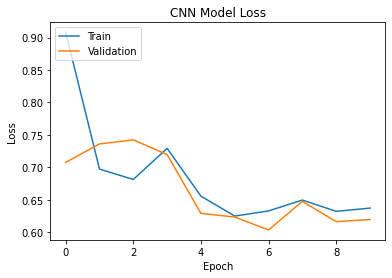

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

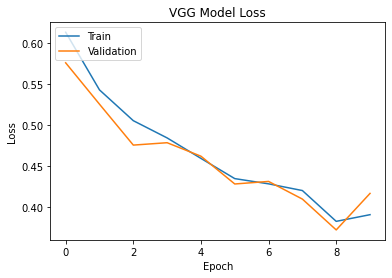

In [ ]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

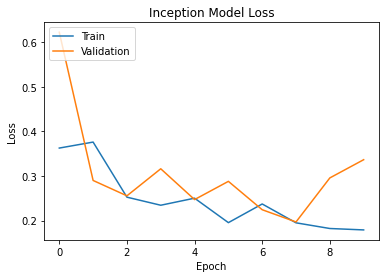

In [ ]:
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Inception Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

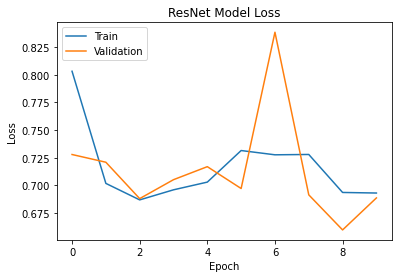

In [ ]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We can see from the above that the **Inception Model** performs the **best with respect to loss**. Its loss value (0.23) for validation data is lower than that of its training data (0.27). And among all models trained, these are the lowest values obtained for loss.







The **worst performing model in terms of loss** is the **ResNet Model50**, whose loss for training data is 0.69 and that for validation data is 0.7. Not only are these the highest values for loss among all models examined, but the validation loss is greater than training loss. This is a sign of underfitting in the model. 

#####**Accuracy Plots:**


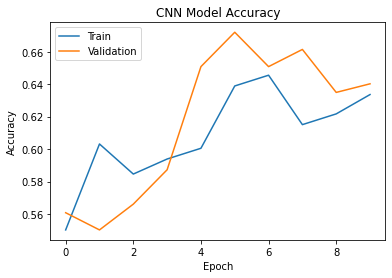

In [ ]:
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

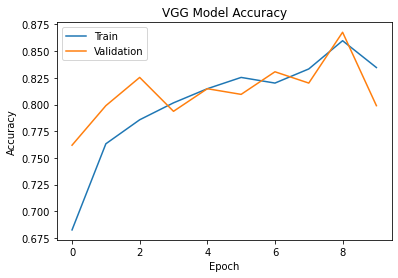

In [ ]:
plt.plot(vgg_history.history['acc'])
plt.plot(vgg_history.history['val_acc'])
plt.title('VGG Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

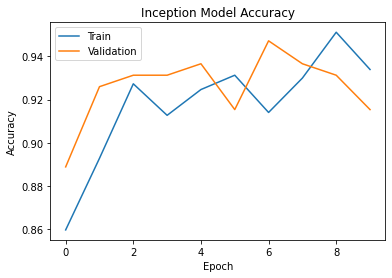

In [ ]:
plt.plot(inception_history.history['acc'])
plt.plot(inception_history.history['val_acc'])
plt.title('Inception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

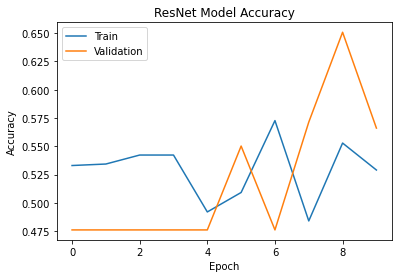

In [ ]:
plt.plot(resnet_history.history['acc'])
plt.plot(resnet_history.history['val_acc'])
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

As seen from the above plots, the **Inception Model** has the **best performance in terms of accuracy**; its training accuracy is nearly 0.9, and validation accuracy is nearly 0.93. The validation accuracy is higher than the training accuracy and these are the highest values for accuracy. Thsi indicates that the Inception model fits our data well. 



The **worst performing model in terms of accuracy** is also the **ResNet50 model**. It has the lowest scores for training and validation accuracy (0.53 and 0.55, respectively), which once again indicates a poor fit of our data.





---



Comparing these results, once can see that the InceptionV3 model performs the best for binry classification of cataract images. Its good fit of the image data is indicated in its high accuracy and low loss values. Moving forward in this project, I will be using the InceptionV3 model for cataract identification.

In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 5.2 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 182 kB 62.1 MB/s 
     |████████████████████████████████| 4.7 MB 42.2 MB/s 
     |████████████████████████████████| 237 kB 44.8 MB/s 
     |████████████████████████████████| 164 kB 49.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 51 kB 5.0 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19615 sha256=3291834adf9f7d600b5e8d4dee5c4b1ba51f2082d23a776d8e44fc53cff7fcce
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st

@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/inc1.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Cataract Identification
         """
         )

file = st.file_uploader("Please upload a color fundus photograph", type=["jpg"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (299,299)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    st.write(predictions)
    class_names = ['cataract', 'normal']
    string="This image most likely is: " + class_names[np.argmax(predictions)]
    st.success(string)
      

Writing app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[##................] / loadDep:strip-ansi: sill resolveWithNewModule ansi-regex

npx: installed 22 in 6.086s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.73.254.133:8501

your url is: https://strong-buckets-try-34-73-254-133.loca.lt
2022-11-09 05:53:28.802988: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
1/1 [==============================] - 1s 864ms/step
